# London Weather and Bike Hires

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp 
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter,filtfilt
from sklearn.linear_model import LinearRegression


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Reading our csv files

In [85]:
dfB = pd.read_csv("Data-Table 1.csv",thousands=',')
dfW = pd.read_csv("london_weather.csv",parse_dates=["date"])

## Exporitory Analysis of the Dataset

### <u> Target </u>
- Number of bikes hires

### <u> Features </u>
- Cloud Cover
- Sunshine
- Global radiation
- Max Temperature
- Mean Temperature
- Min Temp
- Precipitation
- Pressure
- Snow Depth

Getting general information on our files like the shape, coloumn names, and types

In [455]:
print(dfB.shape)
print(dfW.shape)

(4538, 18)
(15341, 10)


In [456]:
print(dfB.columns)
print(dfW.columns)

Index(['Day', 'Number of Bicycle Hires', 'Unnamed: 2', 'Month',
       'Number of Bicycle Hires.1', 'Unnamed: 5', 'Year',
       'Number of Bicycle Hires.2', 'Unnamed: 8', 'Month.1',
       'Average Hire Time (mins)', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17'],
      dtype='object')
Index(['date', 'cloud_cover', 'sunshine', 'global_radiation', 'max_temp',
       'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth'],
      dtype='object')


In [459]:
print(dfB.info())
print(dfW.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4538 entries, 0 to 4537
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Day                        4538 non-null   object 
 1   Number of Bicycle Hires    4538 non-null   int64  
 2   Unnamed: 2                 0 non-null      float64
 3   Month                      150 non-null    object 
 4   Number of Bicycle Hires.1  150 non-null    float64
 5   Unnamed: 5                 0 non-null      float64
 6   Year                       142 non-null    object 
 7   Number of Bicycle Hires.2  149 non-null    object 
 8   Unnamed: 8                 0 non-null      float64
 9   Month.1                    150 non-null    object 
 10  Average Hire Time (mins)   150 non-null    float64
 11  Unnamed: 11                0 non-null      float64
 12  Unnamed: 12                1 non-null      object 
 13  Unnamed: 13                1 non-null      objec

In [ ]:
print(dfB.describe())
print(dfW.describe())

A sample graph of one of our features - snow depth

In [ ]:
sns.lineplot(x=dfW.index, y=dfW["snow_depth"],  color='dodgerblue')

## Data Cleaning

We will perform the following steps
- Dropping unnecessary columns
- Ensuring the date column is of the correct type and format
- Changing the ranges of both data sets so they are the same
- Creating the index for our datasets
- Removing different values

Dropping unnessiscary colunms from the bike data set

In [86]:
dfB = dfB.drop(columns = ['Unnamed: 2','Month','Number of Bicycle Hires.1', 'Unnamed: 5', 'Year',
       'Number of Bicycle Hires.2', 'Unnamed: 8', 'Month.1',
       'Average Hire Time (mins)', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17'])


Converting the timestamps to dates and formatting the dates

In [87]:
dfB = dfB.convert_dtypes()
dfB["Day"] = pd.to_datetime(dfB["Day"])
dfW = dfW.convert_dtypes()
dfW["date"] = pd.to_datetime(dfW["date"])

dfB["Day"] = dfB["Day"].dt.strftime('%Y-%m-%d')
dfW["date"] = dfW["date"].dt.strftime('%Y-%m-%d')

Splicing the data sets so they line up with each other

In [88]:
dfW = dfW[~(dfW['date'] < '2010-07-30')]
dfB = dfB[~(dfB['Day'] > '2020-12-31')]

a graph of the missing values in the weather data sets

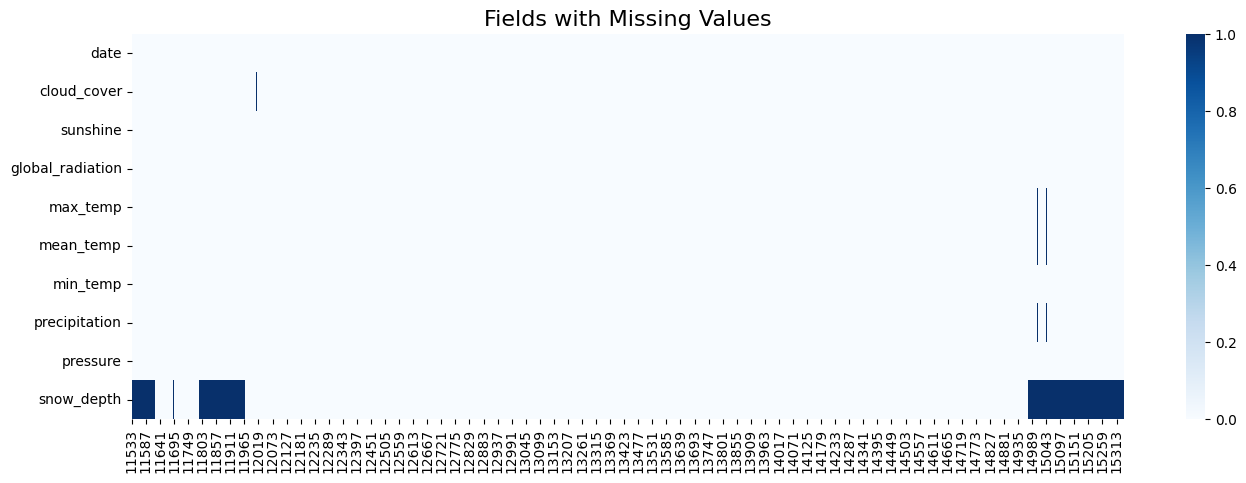

In [89]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
sns.heatmap(dfW.isna().transpose(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
plt.show()

In [90]:
temp = (dfW.isna().any(axis=1))

print(temp[temp].index)


#2011-10-07
#2020-01-01

Int64Index([11533, 11534, 11535, 11536, 11537, 11538, 11539, 11540, 11541,
            11542,
            ...
            15331, 15332, 15333, 15334, 15335, 15336, 15337, 15338, 15339,
            15340],
           dtype='int64', length=645)


In [91]:
dfW = dfW[~(dfW['date'] < '2011-10-07')]
dfW = dfW[~(dfW['date'] > '2019-12-31')]
dfB = dfB[~(dfB['Day'] < '2011-10-07')]
dfB = dfB[~(dfB['Day'] > '2019-12-31')]

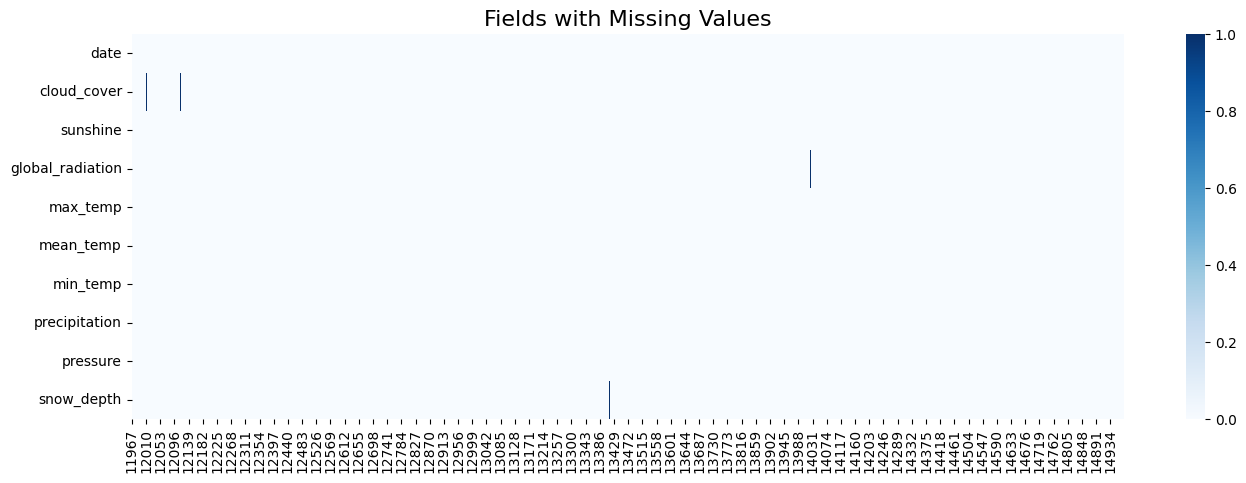

In [92]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
sns.heatmap(dfW.isna().transpose(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
plt.show()

Setting the index to the dates coloumn

In [93]:
dfW["date"] = pd.to_datetime(dfW["date"])
dfB["Day"] = pd.to_datetime(dfB["Day"])
dfB = dfB.set_index("Day")
dfW = dfW.set_index("date")

Getting the exact amount of nan values 

In [95]:
dfW.isna().sum()


cloud_cover         2
sunshine            0
global_radiation    6
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          3
dtype: int64

Converting the types to floats

In [96]:
dfW["cloud_cover"] = dfW["cloud_cover"].values.astype(float)
dfW["global_radiation"] = dfW["global_radiation"].values.astype(float)
dfW["max_temp"] = dfW["max_temp"].values.astype(float)
dfW["mean_temp"] = dfW["mean_temp"].values.astype(float)
dfW["min_temp"] = dfW["min_temp"].values.astype(float)
dfW["precipitation"] = dfW["precipitation"].values.astype(float)
dfW["snow_depth"] = dfW["snow_depth"].values.astype(float)

In [75]:
dfW.info()
dfB.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3008 entries, 2011-10-07 to 2019-12-31
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cloud_cover       3008 non-null   float64
 1   sunshine          3008 non-null   Float64
 2   global_radiation  3008 non-null   float64
 3   max_temp          3008 non-null   float64
 4   mean_temp         3008 non-null   float64
 5   min_temp          3008 non-null   float64
 6   precipitation     3008 non-null   float64
 7   pressure          3008 non-null   Int64  
 8   snow_depth        3008 non-null   float64
dtypes: Float64(1), Int64(1), float64(7)
memory usage: 305.4 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 435 entries, 2010-07-30 to 2011-10-07
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Number of Bicycle Hires  435 non-null    Int64
dtypes: Int64(1)

interpolating each colounm with nan values

In [97]:
dfW['cloud_cover'] = dfW['cloud_cover'].interpolate()
dfW['global_radiation'] = dfW['global_radiation'].interpolate()
dfW['max_temp'] = dfW['max_temp'].interpolate()
dfW['mean_temp'] = dfW['mean_temp'].interpolate()
dfW['min_temp'] = dfW['min_temp'].interpolate()
dfW['precipitation'] = dfW['precipitation'].interpolate()
dfW['snow_depth'] = dfW['snow_depth'].interpolate()
dfW['snow_depth'] = dfW['snow_depth'].bfill()


## Data Representation

This allows us to see how our data relates to each other. 
We can graph all the features individually.
We also graphed the features on a correlation plot so we would be able to ensure no feature was too highly correlated so it would not have a negative impact on our graph.

creating a graph with all the weather value coloums

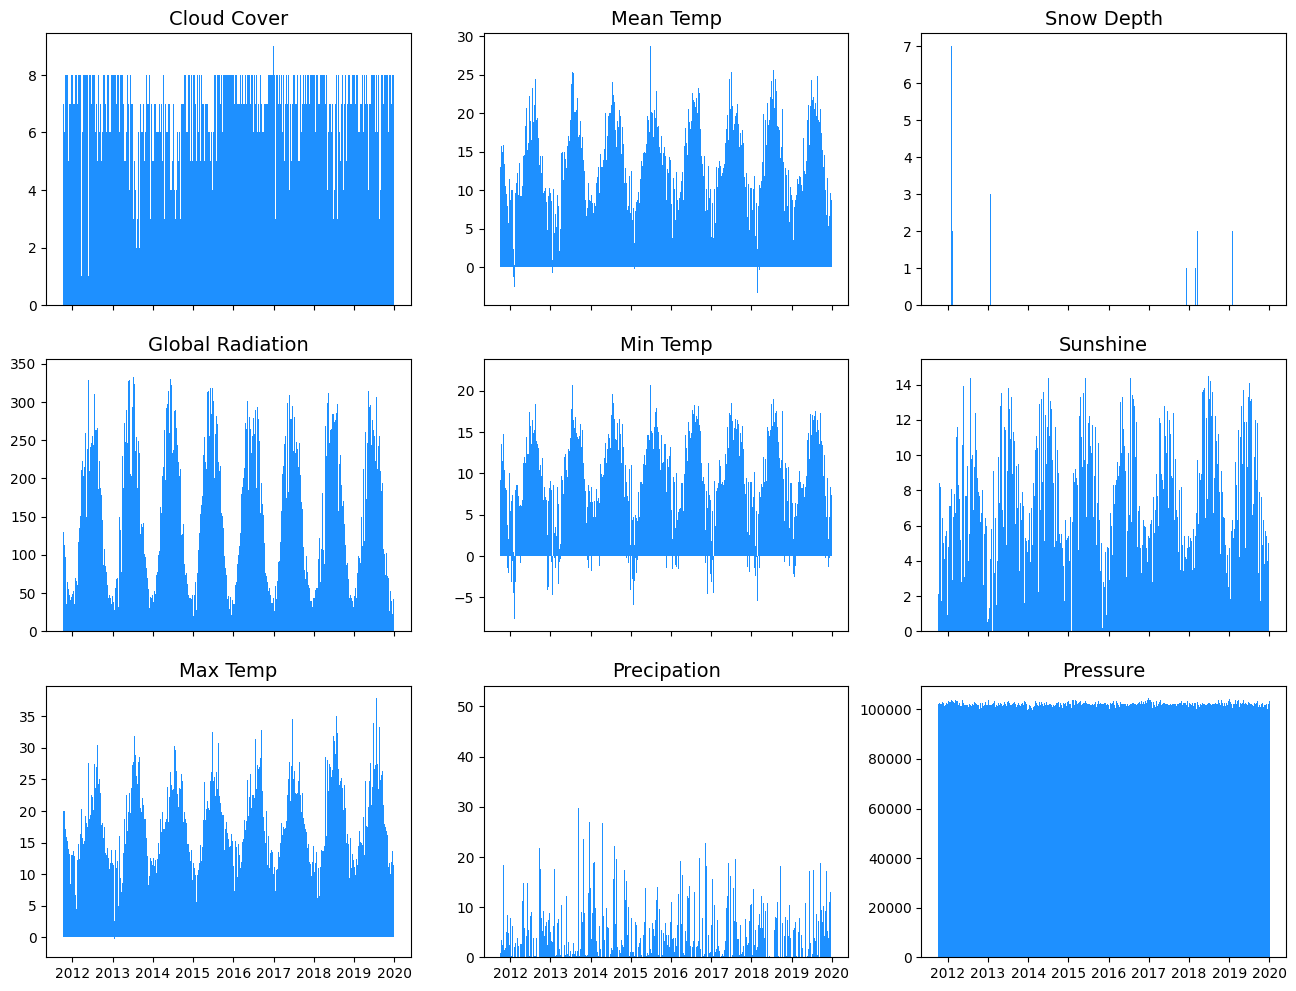

In [43]:
fig, ax = plt.subplots(ncols=3, nrows=3, sharex=True, figsize=(16,12))

ax[0][0].bar(dfW.index, dfW.cloud_cover, width=5, color='dodgerblue')
ax[0][0].set_title('Cloud Cover', fontsize=14)
ax[1][0].bar(dfW.index, dfW.global_radiation, width=5, color='dodgerblue')
ax[1][0].set_title('Global Radiation', fontsize=14)
ax[2][0].bar(dfW.index, dfW.max_temp, width=5, color='dodgerblue')
ax[2][0].set_title('Max Temp', fontsize=14)
ax[0][1].bar(dfW.index, dfW.mean_temp, width=5, color='dodgerblue')
ax[0][1].set_title('Mean Temp', fontsize=14)
ax[1][1].bar(dfW.index, dfW.min_temp, width=5, color='dodgerblue')
ax[1][1].set_title('Min Temp', fontsize=14)
ax[2][1].bar(dfW.index, dfW.precipitation, width=5, color='dodgerblue')
ax[2][1].set_title('Precipation', fontsize=14)
ax[0][2].bar(dfW.index, dfW.snow_depth, width=5, color='dodgerblue')
ax[0][2].set_title('Snow Depth', fontsize=14)
ax[1][2].bar(dfW.index, dfW.sunshine, width=5, color='dodgerblue')
ax[1][2].set_title('Sunshine', fontsize=14)
ax[2][2].bar(dfW.index, dfW.pressure, width=5, color='dodgerblue')
ax[2][2].set_title('Pressure', fontsize=14)

plt.show()

<AxesSubplot: xlabel='Day', ylabel='Number of Bicycle Hires'>

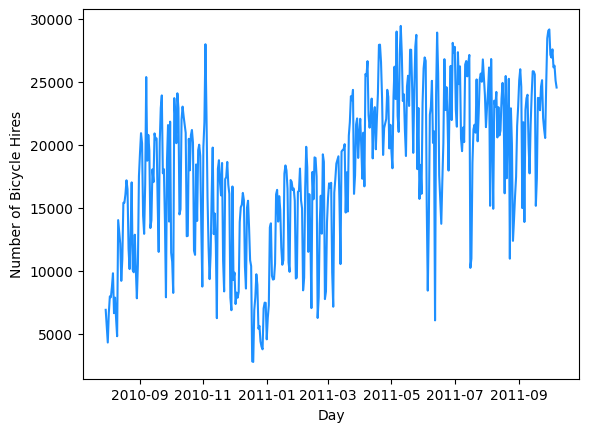

In [71]:
sns.lineplot(x=dfB.index, y=dfB["Number of Bicycle Hires"],  color='dodgerblue')

Combining the two datasets

In [98]:
frames = [dfW, dfB['Number of Bicycle Hires']]
df = pd.concat(frames, axis=1)

Creating a correlation graph

<AxesSubplot: >

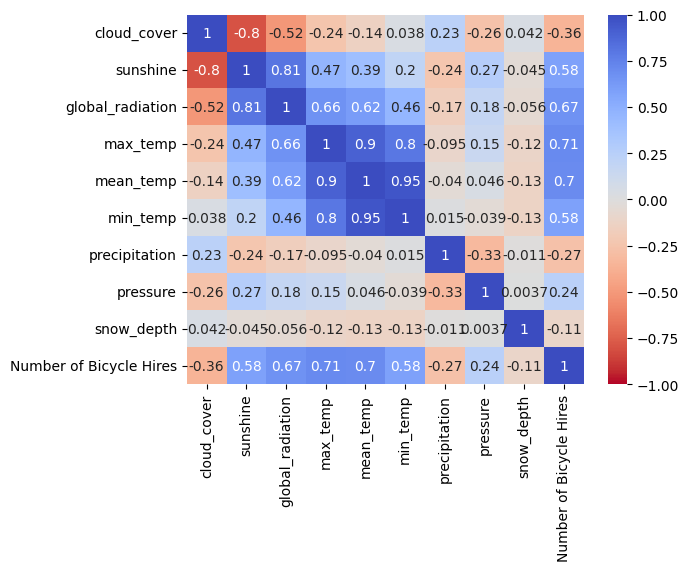

In [100]:
corrmat = df.corr()
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r')

## Data Pre-Processing

Here we tried out different methods to create our models

Normalising the data

In [101]:
scaler = MinMaxScaler()
# fit and transform the data
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df_norm

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,Number of Bicycle Hires
0,0.444444,0.095238,0.155963,0.457801,0.507788,0.561873,0.000000,0.604938,0.0,0.301856
1,0.888889,0.006803,0.082569,0.570332,0.504673,0.555184,0.015504,0.662037,0.0,0.210212
2,0.666667,0.061224,0.128440,0.552430,0.613707,0.642140,0.000000,0.609568,0.0,0.202866
3,0.777778,0.068027,0.131498,0.542199,0.669782,0.785953,0.000000,0.601852,0.0,0.297098
4,0.666667,0.142857,0.171254,0.542199,0.660436,0.779264,0.000000,0.620370,0.0,0.325647
...,...,...,...,...,...,...,...,...,...,...
3003,0.888889,0.000000,0.000000,0.276215,0.336449,0.474916,0.000000,0.768519,0.0,0.117692
3004,0.888889,0.000000,0.000000,0.283887,0.355140,0.474916,0.000000,0.884259,0.0,0.113322
3005,0.666667,0.149660,0.051988,0.324808,0.373832,0.501672,0.000000,0.842593,0.0,0.125426
3006,0.000000,0.244898,0.076453,0.268542,0.305296,0.304348,0.000000,0.782407,0.0,0.181634


In [107]:
T = 86400         # Sample Period
fs = 0.00001       # sample rate, Hz
cutoff = 0.000001      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

In [108]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [109]:
# Filter the data, and plot both the original and filtered signals.
df_noise = butter_lowpass_filter(df, cutoff, fs, order)
fig = go.Figure()
fig.add_trace(go.Scatter(
            y = data,
            line =  dict(shape =  'spline' ),
            name = 'signal with noise'
            ))
fig.add_trace(go.Scatter(
            y = df_noise,
            line =  dict(shape =  'spline' ),
            name = 'filtered signal'
            ))
fig.show()

NameError: name 'data' is not defined

In [110]:
df_noise = pd.DataFrame(df_noise, columns= ('cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp',
       'min_temp', 'precipitation', 'pressure', 'snow_depth','Number of Bicycle Hires'))
df_noise.head()


,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,Number of Bicycle Hires
0,52.024767,-189.574347,404.058229,2609.188053,6993.866103,13478.351097,20566.964933,25457.360952,26403.659281,24522.516588
1,68.460674,-43.455354,699.069762,3044.256394,7479.452412,13774.590537,20219.101259,23787.746393,22649.218327,18150.729308
2,67.107601,-32.160605,720.315136,3067.688773,7490.192429,13748.629412,20123.995559,23586.593121,22305.791697,17640.025769
3,55.627731,-180.33402,420.154931,2631.74936,7017.774288,13490.398997,20543.50068,25364.737129,26204.809187,24191.660969
4,50.970574,-224.08,333.099871,2507.294357,6887.684136,13432.012346,20695.968031,25928.343843,27401.702925,26176.68758


## Model Training & Testing

In [111]:
from sklearn.tree import DecisionTreeRegressor

Seperating our targets and features

In [143]:
features = [ 'cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp',
       'min_temp', 'precipitation', 'pressure', 'snow_depth']

target = 'Number of Bicycle Hires'

In [141]:
features2 = [  'precipitation']


In [121]:
for i, (train_index, test_index) in enumerate(kf.split(df_norm)):
    X_train, X_test, Y_train, Y_test = features_norm[train_index], features_norm[test_index], targets_norm[train_index], targets_norm[test_index]
    model = DecisionTreeRegressor(random_state=1)
    model.fit(X_train, Y_train)
    print(model.score(X_test, Y_test))

0.22116477872766638
0.21383342314084297
-0.36722775930212403
0.4082198709846323
0.25751283012297355
0.40900004968944936
0.17143226870366257
0.21857874658794763
0.4001598649649877
0.0271776350191959


## Preformance Measures
- Score
- Cross validation mean
- R2 score
- Percentage error

In [178]:
from sklearn.model_selection import cross_val_score, train_test_split
df.columns

Index(['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp',
       'min_temp', 'precipitation', 'pressure', 'snow_depth',
       'Number of Bicycle Hires'],
      dtype='object')

In [123]:
from sklearn.metrics import r2_score

### Models with regular data ###

In [174]:
x_train, x_test, y_train, y_test = train_test_split(df_scale[features], df_scale[target], test_size = 0.3, random_state=0)

#### Liner Regression ####

In [175]:
model = LinearRegression()
model.fit(x_train, y_train)
model.score(x_test,y_test)

0.6532032325548451

In [176]:
scores = cross_val_score(model, x_train, y_train, cv=10)

print("Cross-validation scores:", scores)
print("Mean score:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.59730643 0.62090433 0.62543099 0.60358876 0.67739862 0.66110447
 0.69384179 0.61973672 0.66702102 0.66117279]
Mean score: 0.6427505917423755
Standard deviation: 0.03159395302543477


In [177]:
y_prediction = model.predict(x_test)
r2_score(y_prediction, y_test)

0.500296880028843

#### Decison Tree Regressor ####

In [184]:
model = DecisionTreeRegressor()
model.fit(x_train, y_train)
model.score(x_test,y_test)

0.32325222779678986

In [150]:
scores = cross_val_score(model, x_train, y_train, cv=10)

print("Cross-validation scores:", scores)
print("Mean score:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.23965589 0.40863555 0.41624756 0.34701402 0.25466147 0.36431939
 0.32731649 0.19752104 0.38198924 0.42352796]
Mean score: 0.33608886048575526
Standard deviation: 0.07587155919952672


In [185]:
y_prediction = model.predict(x_test)
r2_score(y_prediction, y_test)

0.34735059881544883

### Models with normalised data ###

In [152]:
x_train, x_test, y_train, y_test = train_test_split(df_norm[features], df_norm[target], test_size = 0.3, random_state=0)

#### Liner Regression ####

In [153]:
model = LinearRegression()
model.fit(x_train, y_train)
model.score(x_test,y_test)

0.6532032325548451

In [154]:
scores = cross_val_score(model, x_train, y_train, cv=10)

print("Cross-validation scores:", scores)
print("Mean score:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.59730643 0.62090433 0.62543099 0.60358876 0.67739862 0.66110447
 0.69384179 0.61973672 0.66702102 0.66117279]
Mean score: 0.6427505917423756
Standard deviation: 0.03159395302543477


In [155]:
y_prediction = model.predict(x_test)
r2_score(y_prediction, y_test)

0.5002968800288432

#### Decison Tree Regressor ####

In [156]:
model = DecisionTreeRegressor()
model.fit(x_train, y_train)
model.score(x_test,y_test)

0.35556788965938335

In [157]:
scores = cross_val_score(model, x_train, y_train, cv=10)

print("Cross-validation scores:", scores)
print("Mean score:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.20057226 0.39854536 0.42432512 0.35658897 0.2515828  0.3593383
 0.28916939 0.24446293 0.36154638 0.41794757]
Mean score: 0.33040790814214643
Standard deviation: 0.07468347808521529


In [158]:
y_prediction = model.predict(x_test)
r2_score(y_prediction, y_test)

0.3667158904845983

### Models with filtered data ###

#### (with all the features) ####

In [159]:
x_train, x_test, y_train, y_test = train_test_split(df_noise[features], df_noise[target], test_size = 0.3, random_state=0)

#### Liner Regression ####

In [160]:
model = LinearRegression()
model.fit(x_train, y_train)
model.score(x_test,y_test)

0.9999999999999992

In [161]:
scores = cross_val_score(model, x_train, y_train, cv=10)

print("Cross-validation scores:", scores)
print("Mean score:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean score: 0.9999999999999997
Standard deviation: 3.5457679953657254e-16


In [162]:
y_prediction = model.predict(x_test)
r2_score(y_prediction, y_test)

0.9999999999999992

#### Decison Tree Regressor ####

In [163]:
model = DecisionTreeRegressor()
model.fit(x_train, y_train)
model.score(x_test,y_test)

0.9984342862600665

In [164]:
scores = cross_val_score(model, x_train, y_train, cv=10)

print("Cross-validation scores:", scores)
print("Mean score:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.99951723 0.96627151 0.99973113 0.9996606  0.99978087 0.99962612
 0.99963499 0.99974637 0.99971807 0.99968887]
Mean score: 0.9963375760740233
Standard deviation: 0.010022274633875538


In [165]:
y_prediction = model.predict(x_test)
r2_score(y_prediction, y_test)

0.99844975751542

#### (with selected features) ####

In [166]:
x_train, x_test, y_train, y_test = train_test_split(df_noise[features2], df_noise[target], test_size = 0.3, random_state=0)

#### Liner Regression ####

In [167]:
model = LinearRegression()
model.fit(x_train, y_train)
model.score(x_test,y_test)

0.9235139926246501

In [168]:
scores = cross_val_score(model, x_train, y_train, cv=10)

print("Cross-validation scores:", scores)
print("Mean score:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.90453018 0.93464971 0.92738479 0.93680602 0.92000972 0.90856543
 0.92154352 0.90086119 0.91117041 0.90785572]
Mean score: 0.9173376705494729
Standard deviation: 0.012020390993568315


In [169]:
y_prediction = model.predict(x_test)
r2_score(y_prediction, y_test)

0.918890242290315

#### Decison Tree Regressor ####

In [170]:
model = DecisionTreeRegressor()
model.fit(x_train, y_train)
model.score(x_test,y_test)

0.8533930505447761

In [171]:
scores = cross_val_score(model, x_train, y_train, cv=10)

print("Cross-validation scores:", scores)
print("Mean score:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.80831502 0.83199597 0.83147763 0.86838523 0.8307711  0.84702943
 0.84319471 0.83627053 0.83644913 0.84386126]
Mean score: 0.8377750012959615
Standard deviation: 0.014432834344833863


In [172]:
y_prediction = model.predict(x_test)
r2_score(y_prediction, y_test)

0.8559612569329567